In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet101V2

2024-10-28 10:50:30.526944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 10:50:30.604711: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 10:50:30.699824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 10:50:30.800758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 10:50:30.822706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 10:50:30.967960: I tensorflow/core/platform/cpu_feature_gu

In [2]:
train_path = '../data/curated/train'
test_path = '../data/curated/test'

In [3]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [4]:
baseModel = ResNet101V2(weights="imagenet", include_top=False,input_shape = (350,350,3))
for layer in baseModel.layers:
    layer.trainable = False

I0000 00:00:1730073035.029771   22274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-28 10:50:35.030616: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# creating the output layers that merges with the ResNet101v2
x = baseModel.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)

2024-10-28 10:50:38.393439: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1015021568 exceeds 10% of free system memory.
2024-10-28 10:50:38.830908: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1015021568 exceeds 10% of free system memory.
2024-10-28 10:50:39.268459: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1015021568 exceeds 10% of free system memory.


In [6]:
# merging the 2 model together as one
model = Model(inputs= baseModel.input , outputs = x)

In [7]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [8]:
earlystop = EarlyStopping(patience=5)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 15,
                    verbose = 1,
                    validation_data = test_generator,
                    validation_steps = 50,
                    callbacks = [earlystop])

/home/obli/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


2024-10-28 10:50:45.270444: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1015021568 exceeds 10% of free system memory.
2024-10-28 10:50:54.448407: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1015021568 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.4032 - loss: 129.2462

/home/obli/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 521s 5s/step - acc: 0.4042 - loss: 128.6161 - val_acc: 0.5920 - val_loss: 5.0451
Epoch 2/15
 23/100 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - acc: 0.7069 - loss: 5.6937

2024-10-28 11:00:57.198460: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-28 11:01:12.245879: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - acc: 0.6581 - loss: 6.5572 - val_acc: 0.4000 - val_loss: 14.5075
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 904s 9s/step - acc: 0.5954 - loss: 4.3644 - val_acc: 0.5320 - val_loss: 1.1899
Epoch 4/15
 23/100 ━━━━━━━━━━━━━━━━━━━━ 5:26 4s/step - acc: 0.6843 - loss: 0.8505

2024-10-28 11:18:13.768448: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - acc: 0.6797 - loss: 0.8390 - val_acc: 0.5538 - val_loss: 0.9081
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 522s 5s/step - acc: 0.6706 - loss: 0.9116 - val_acc: 0.4880 - val_loss: 1.0779
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - acc: 0.6610 - loss: 1.0090 - val_acc: 0.4923 - val_loss: 1.0540
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - acc: 0.6678 - loss: 0.8952 - val_acc: 0.5720 - val_loss: 0.8795
Epoch 8/15
 23/100 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - acc: 0.7334 - loss: 0.8029

2024-10-28 11:40:01.394162: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - acc: 0.6843 - loss: 0.8934 - val_acc: 0.4769 - val_loss: 1.2612
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 978s 10s/step - acc: 0.6541 - loss: 0.9874 - val_acc: 0.6040 - val_loss: 0.8700
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - acc: 0.7293 - loss: 0.9169 - val_acc: 0.7231 - val_loss: 0.7260
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 516s 5s/step - acc: 0.6767 - loss: 0.7913 - val_acc: 0.6000 - val_loss: 0.9251
Epoch 12/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - acc: 0.7622 - loss: 0.6996 - val_acc: 0.6154 - val_loss: 1.1288
Epoch 13/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - acc: 0.6338 - loss: 1.0928 - val_acc: 0.6280 - val_loss: 0.9045
Epoch 14/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - acc: 0.7274 - loss: 0.6462 - val_acc: 0.6000 - val_loss: 1.0641
Epoch 15/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - acc: 0.8109 - loss: 0.5444 - val_acc: 0.6680 - val_loss: 0.8531


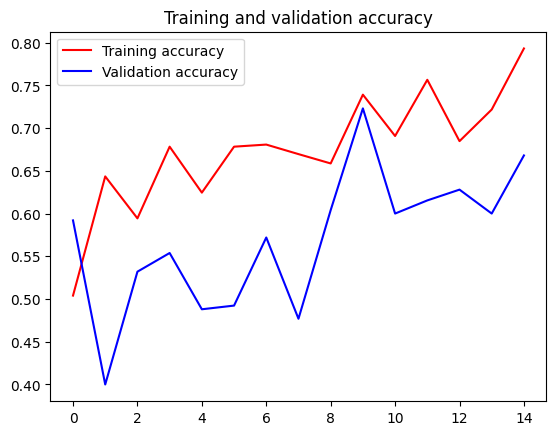

<Figure size 640x480 with 0 Axes>

: 

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()